# Kaggle competition - House Prices: Advanced Regression Techniques

Main sections:
1. Data exploration
2. Data preprocessing
3. Modelling
4. Model evaluation and model tuning
5. Conclusion

In [36]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, \
                                    GridSearchCV, learning_curve, KFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import clone, BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.model_selection import validation_curve
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# Visualisation
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.25)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 100, 'display.max_rows', 100)

In [3]:
train = pd.read_csv('input/train.csv', index_col='Id')
test = pd.read_csv('input/test.csv', index_col='Id')

# 1. Data exploration

Correlation heat map (numerical feature only) below shows that SalePrice is largely correlated to QverallQual, GrLivArea and other features.

Also notice that there are features with high correlation, meaning including all of them will not provide much more information. For instance, GarageArea and GarageCars (obviously a larger garage is able to fit more cars). Therefore I will create a new feature `GarageAreaPerCar` (`GarageArea`/`GarageCars`) replacing those two features.

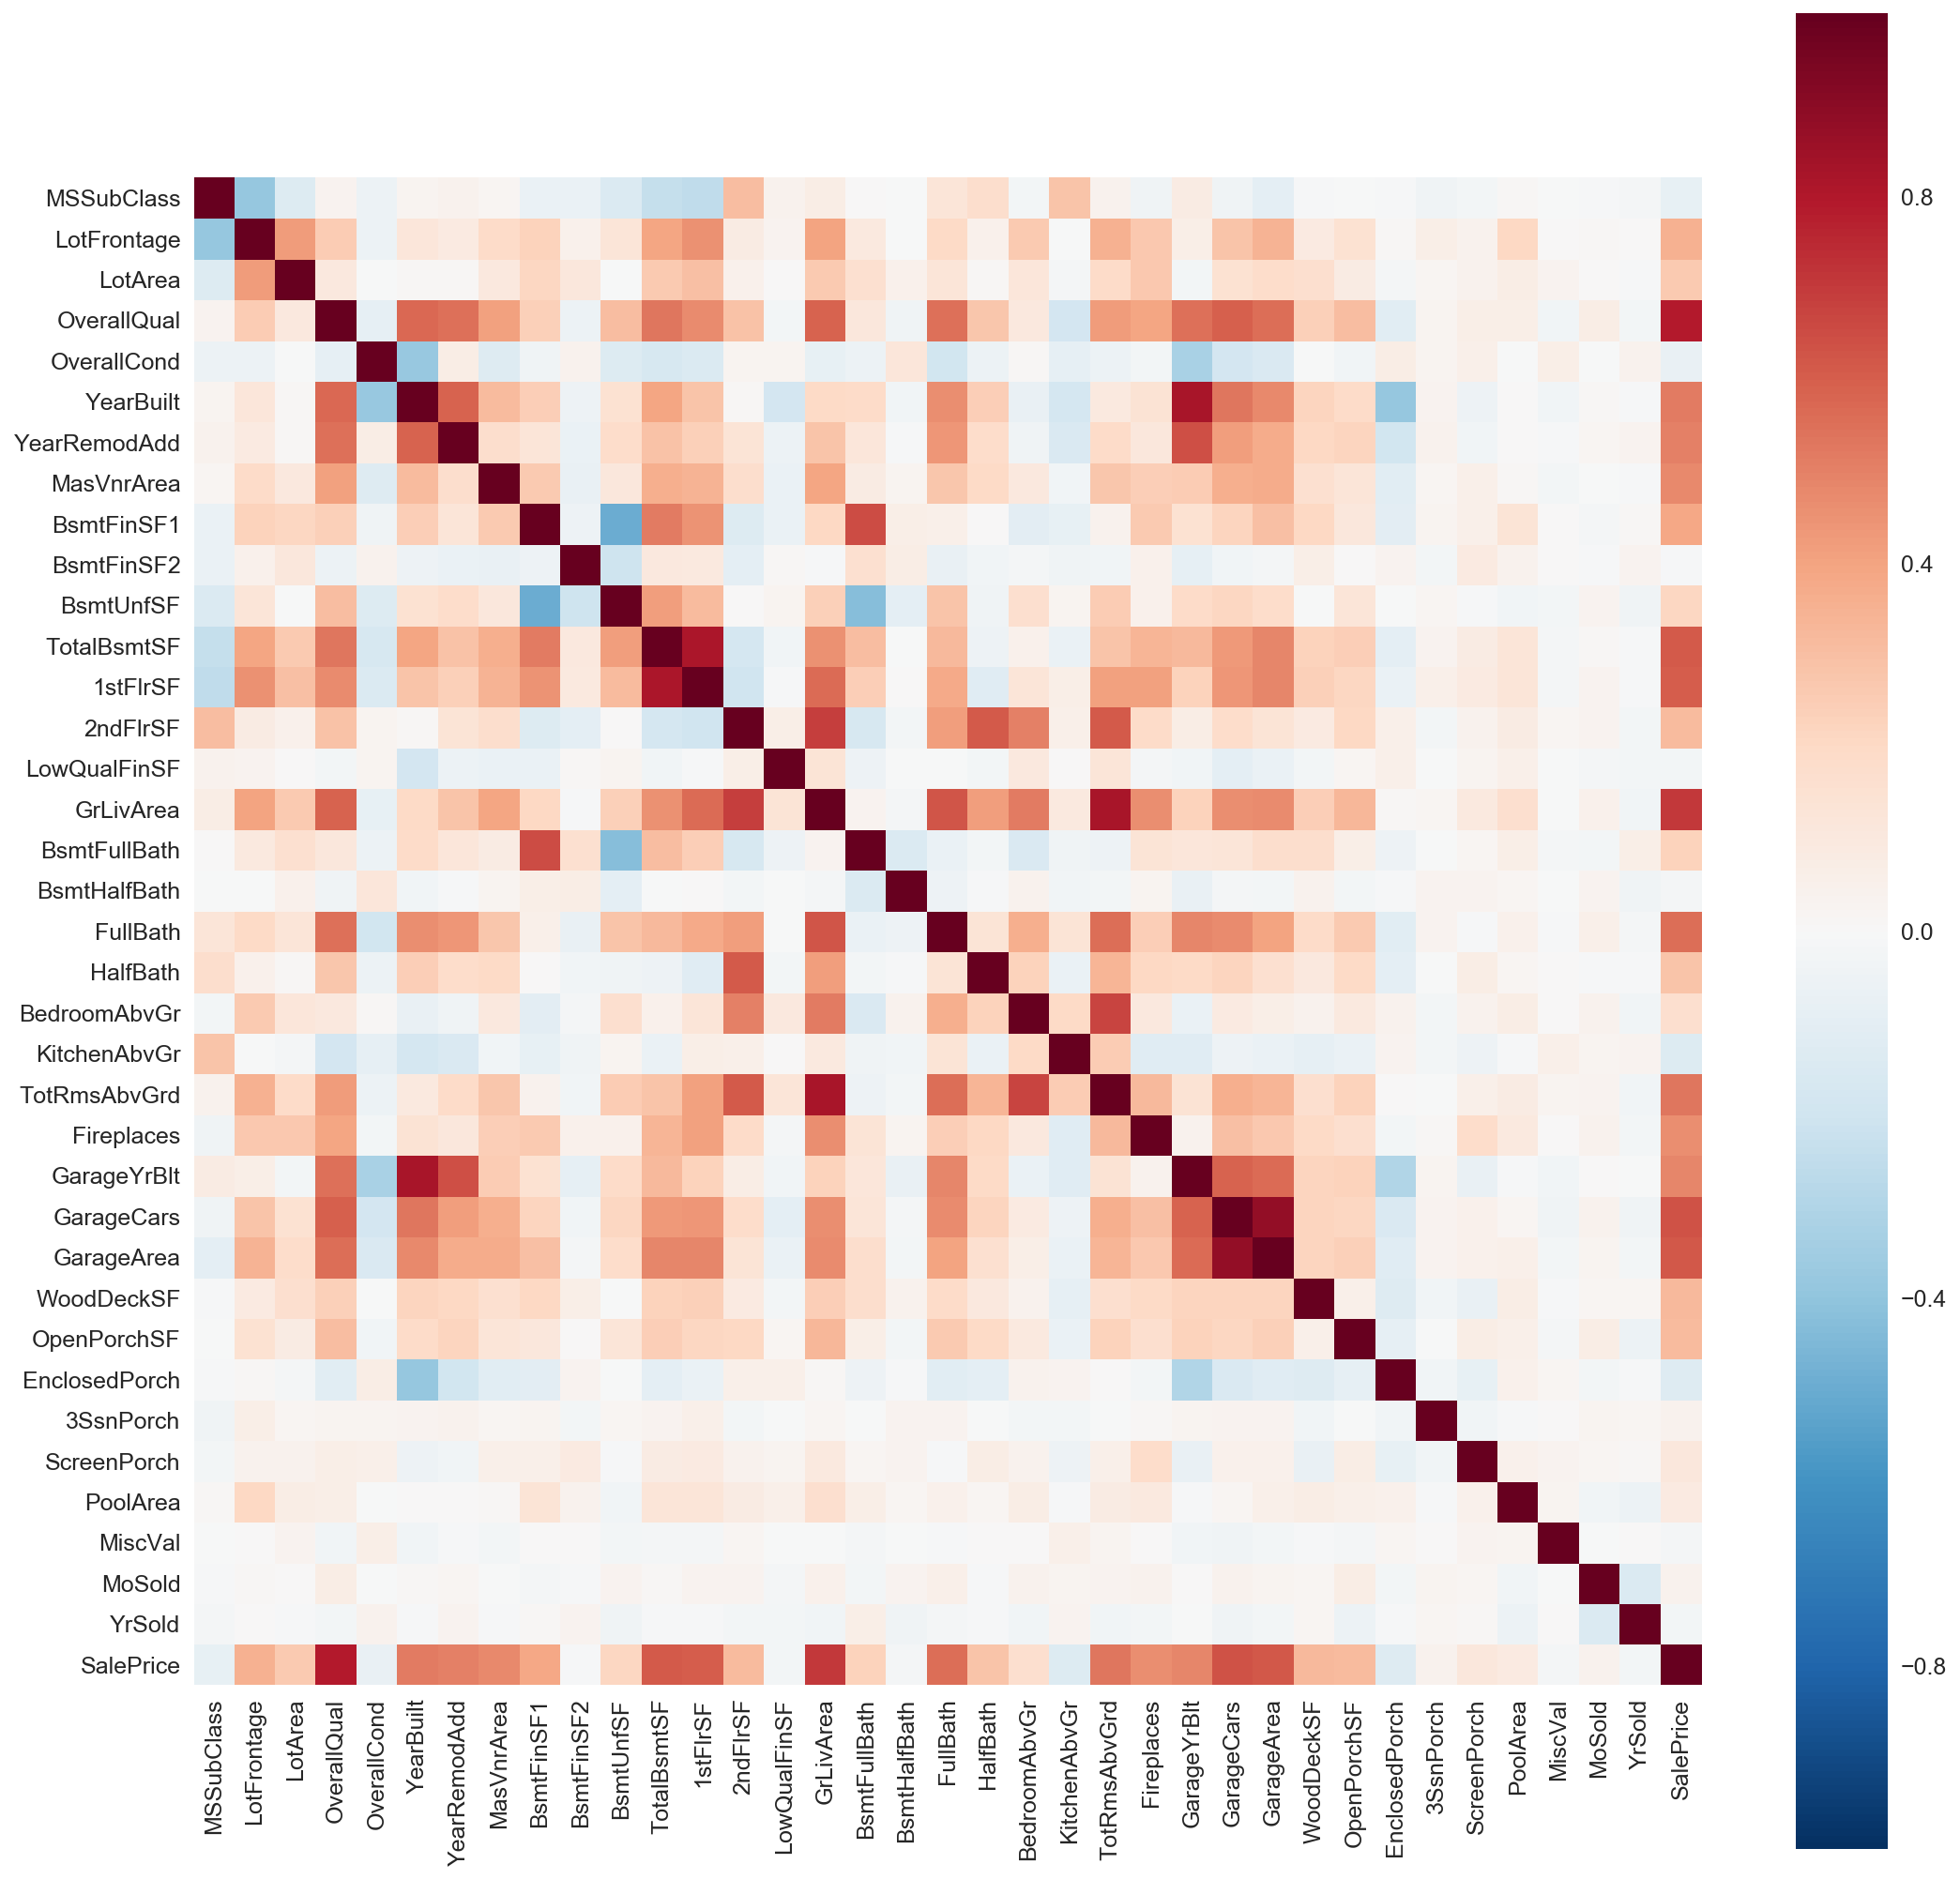

In [24]:
figure(figsize=(18,18))
corrmat = train.corr(method='pearson')
sns.heatmap(corrmat, square=True);

Investigate deeper into features with high correlation with SalePrice. The correlation matrix is a square matrix containing the Pearson product-moment correlation coefficients, which measure the linear dependence between pairs of features. 

Most of the features shown in the heatmap seem to make sense as those are the items I would probably prioritise when buying a house, in addition to location and insulation (and more).

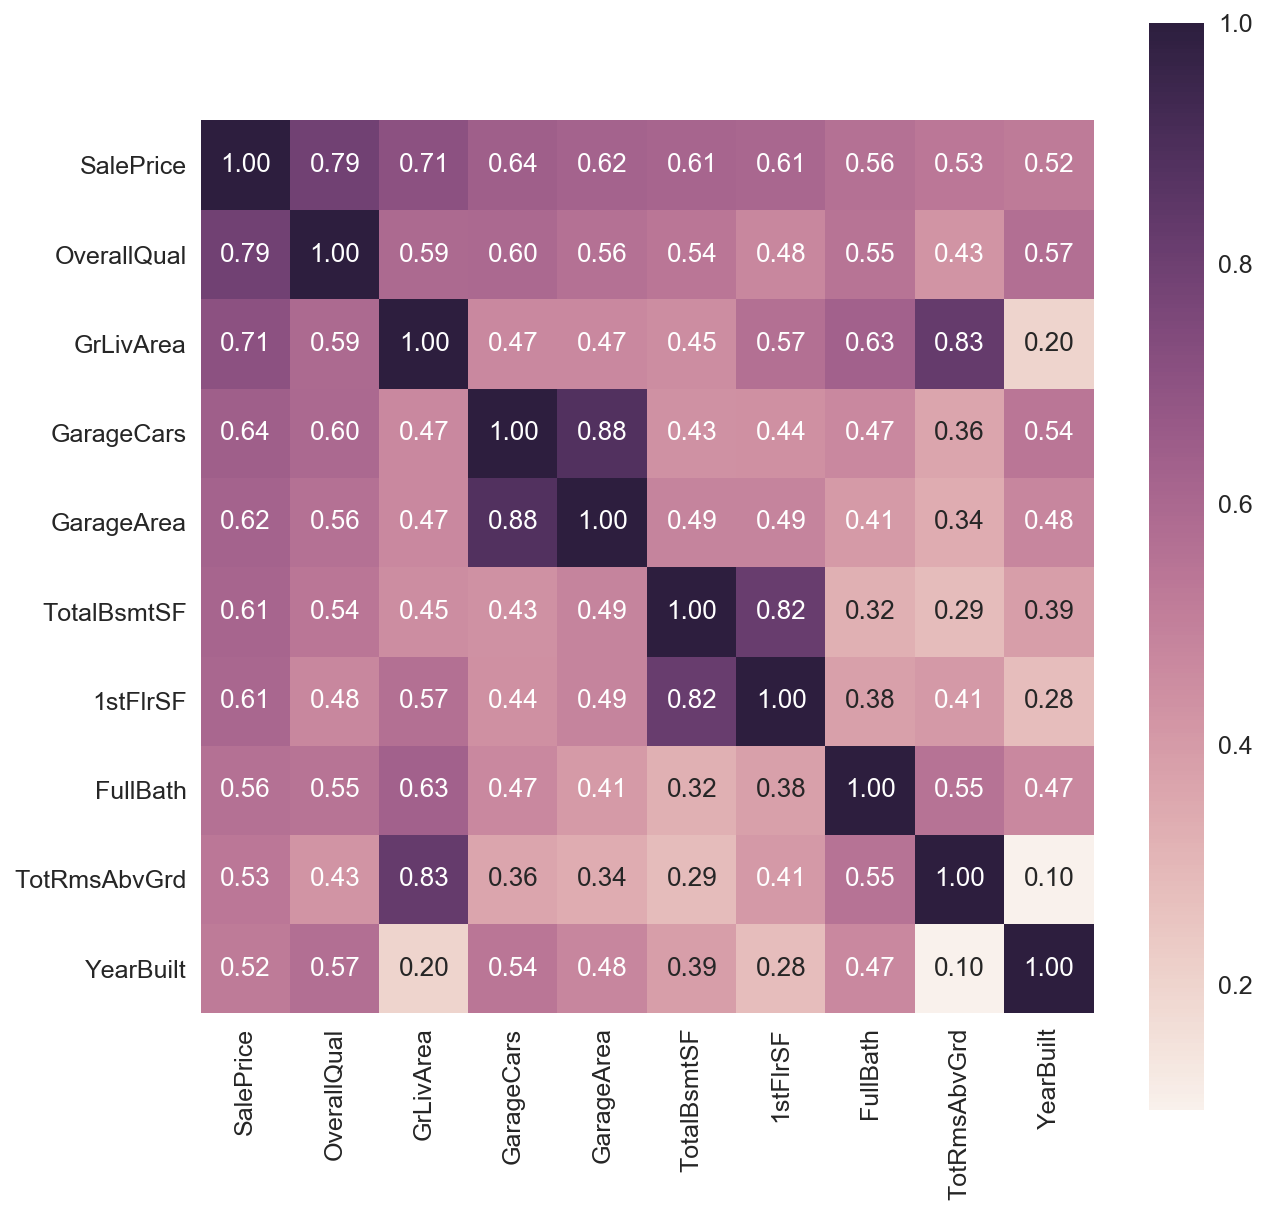

In [25]:
figure(figsize=(10,10))
high_corr_cols = corrmat.nlargest(10, 'SalePrice').index.values
cm = np.corrcoef(train[high_corr_cols].values.T)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 13},
                 yticklabels=high_corr_cols,
                 xticklabels=high_corr_cols
                )

Let's look at the pairwise relationship between the selected features in graphics. It allows us to eyeball how the data is distributed and whether there is outliers.

- SalePrice seems to have a skew normal distribution (N.B. **traning a linear regression model does not require the explanatory or target variables to be normally distributed. The normality assumption is only a requirement for certain statistical and hypothesis tests.**)
- There is an exponential relationship between SalePrice and OverallQual 
- There is a diagonal boundary in the `GrLivArea` vs `1stFlrSF` plot. It makes sense as the 1st floor area has to be (or usually is) less than or equal to the ground living area
- There are a lot more houses being built post-year 2000 than pre-year 2000
- SalePrice has some kind of positive (linear and non-linear) relationship with other features 

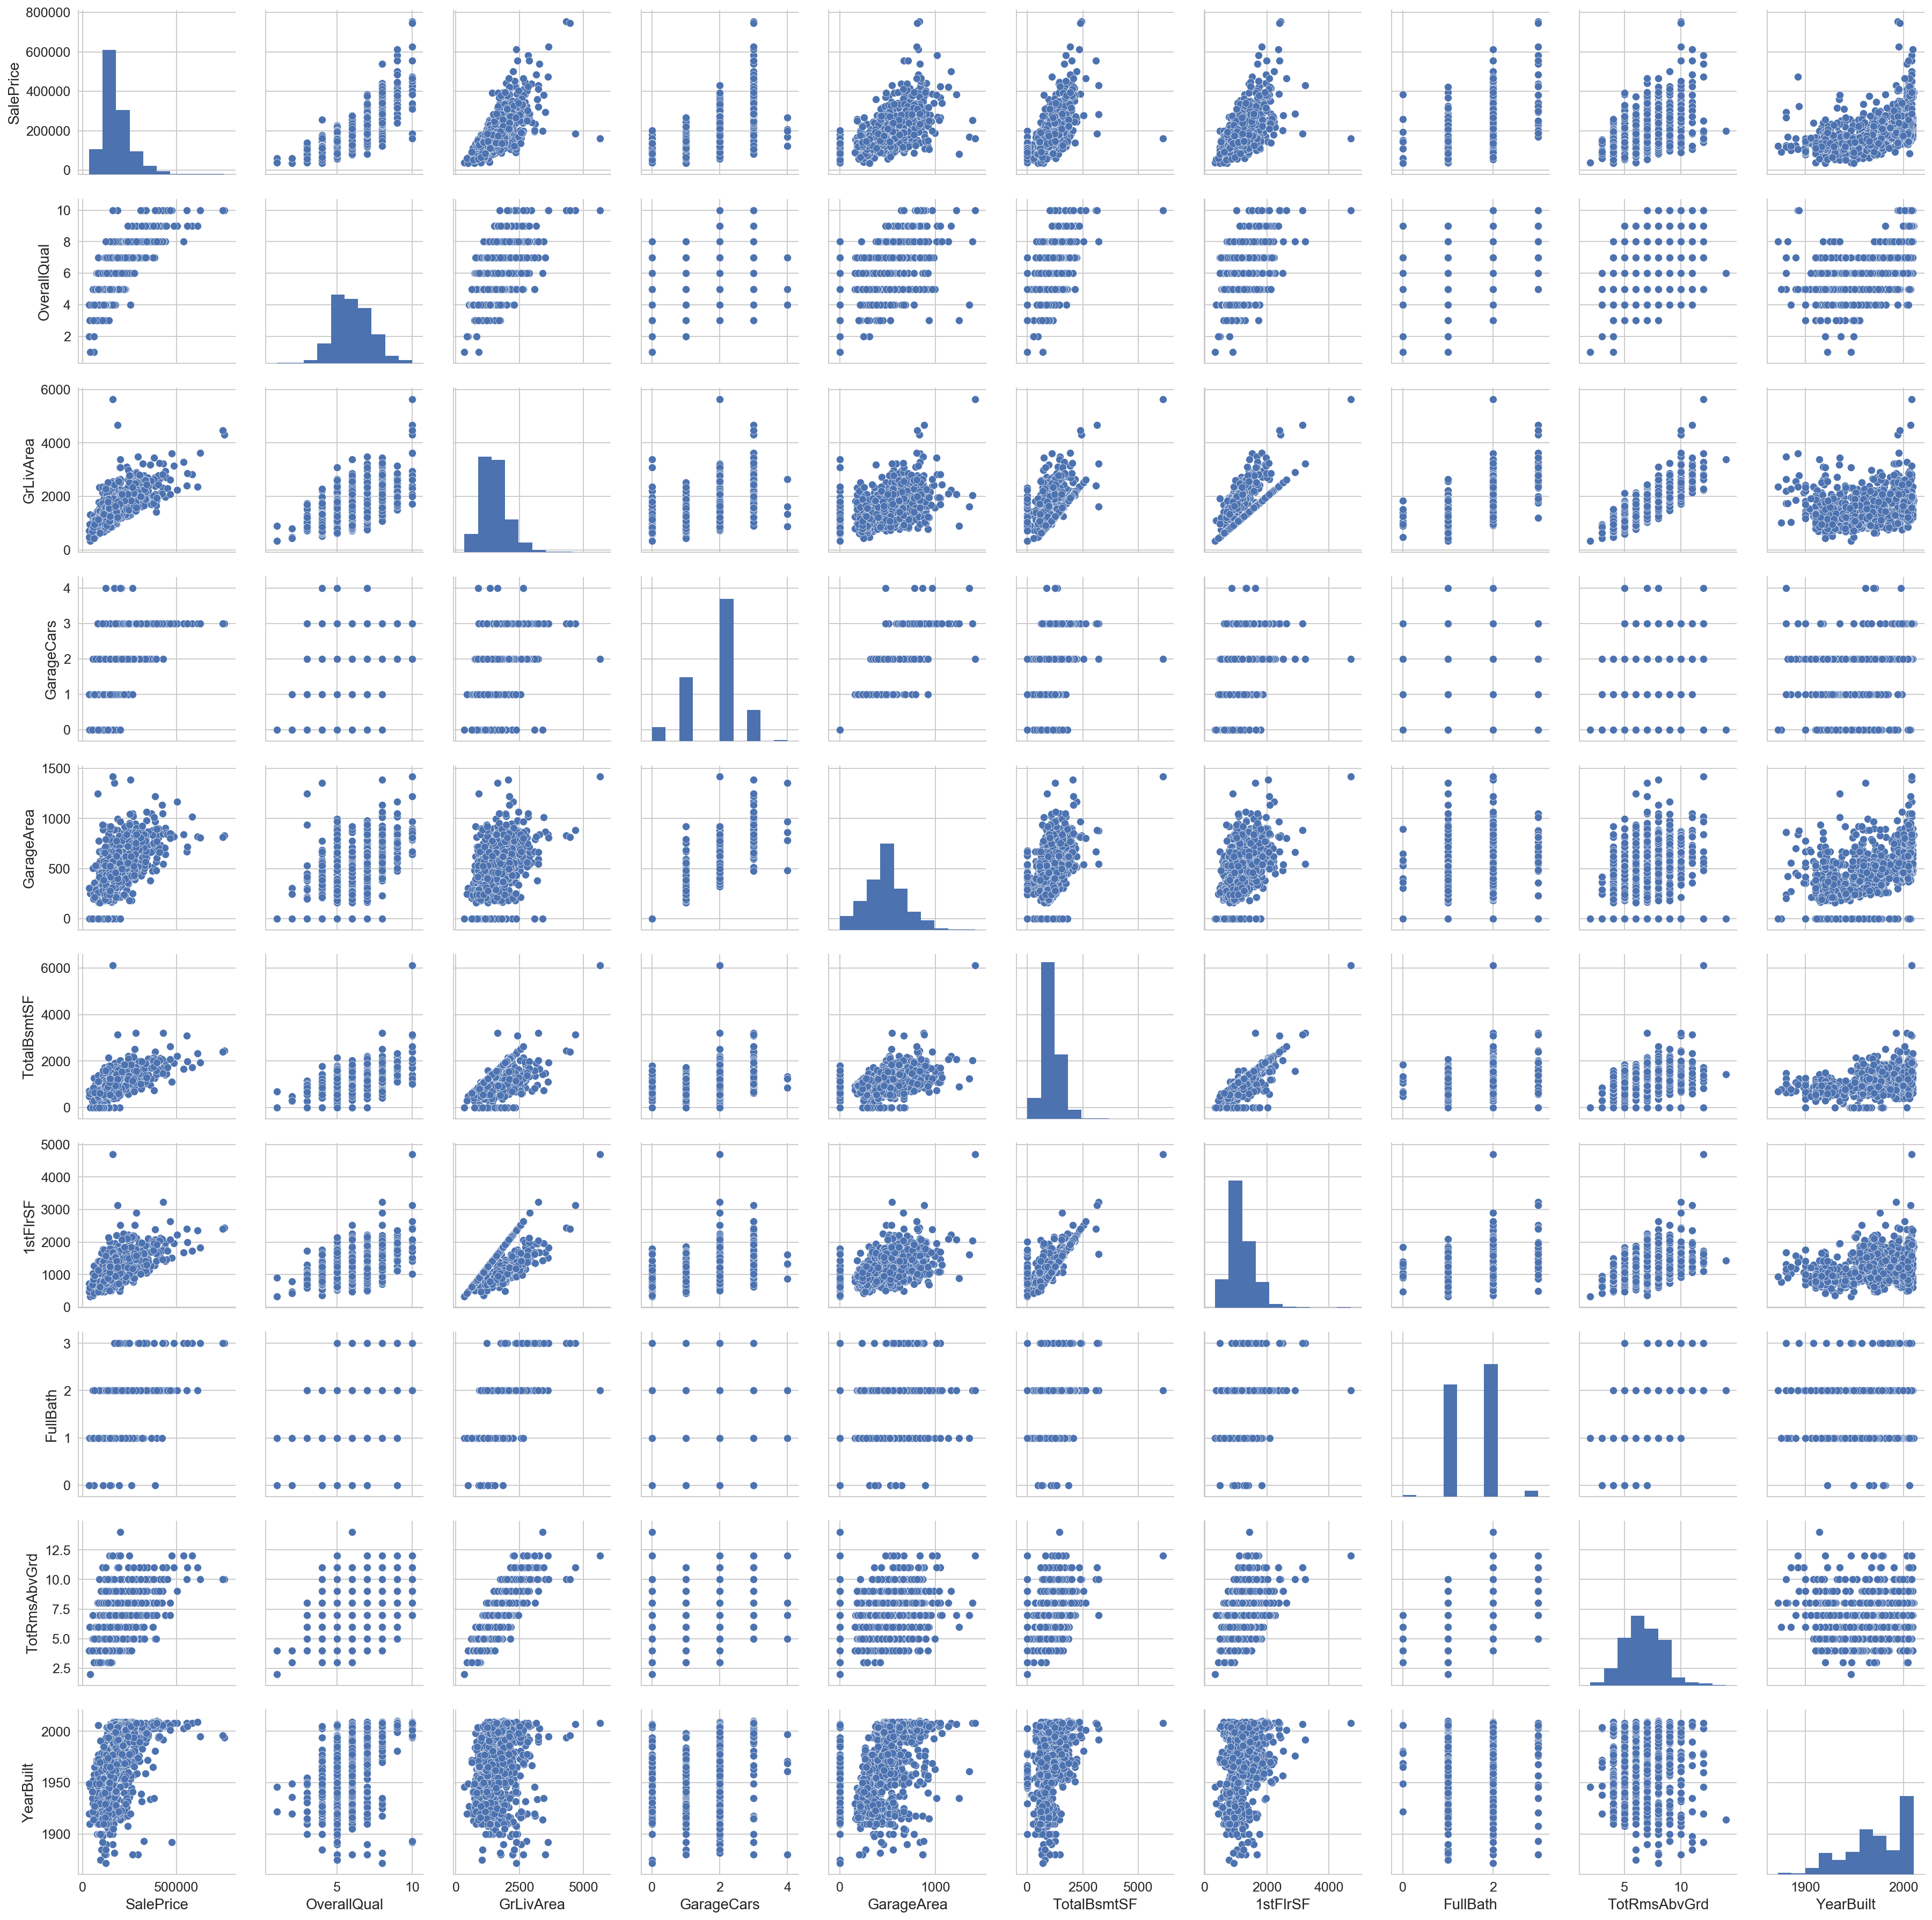

In [26]:
sns.pairplot(train[high_corr_cols], size=2.5);

Another useful thing to examine data is to visualise the distribution with boxplots. Although we could see similar information, the boxplots also give us some ideas on how SalePrice is distributed in each year (quartiles and outliers). There is a trend of house price being more expensive for newer homes - could this be due to inflation and have the prices been corrected?

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


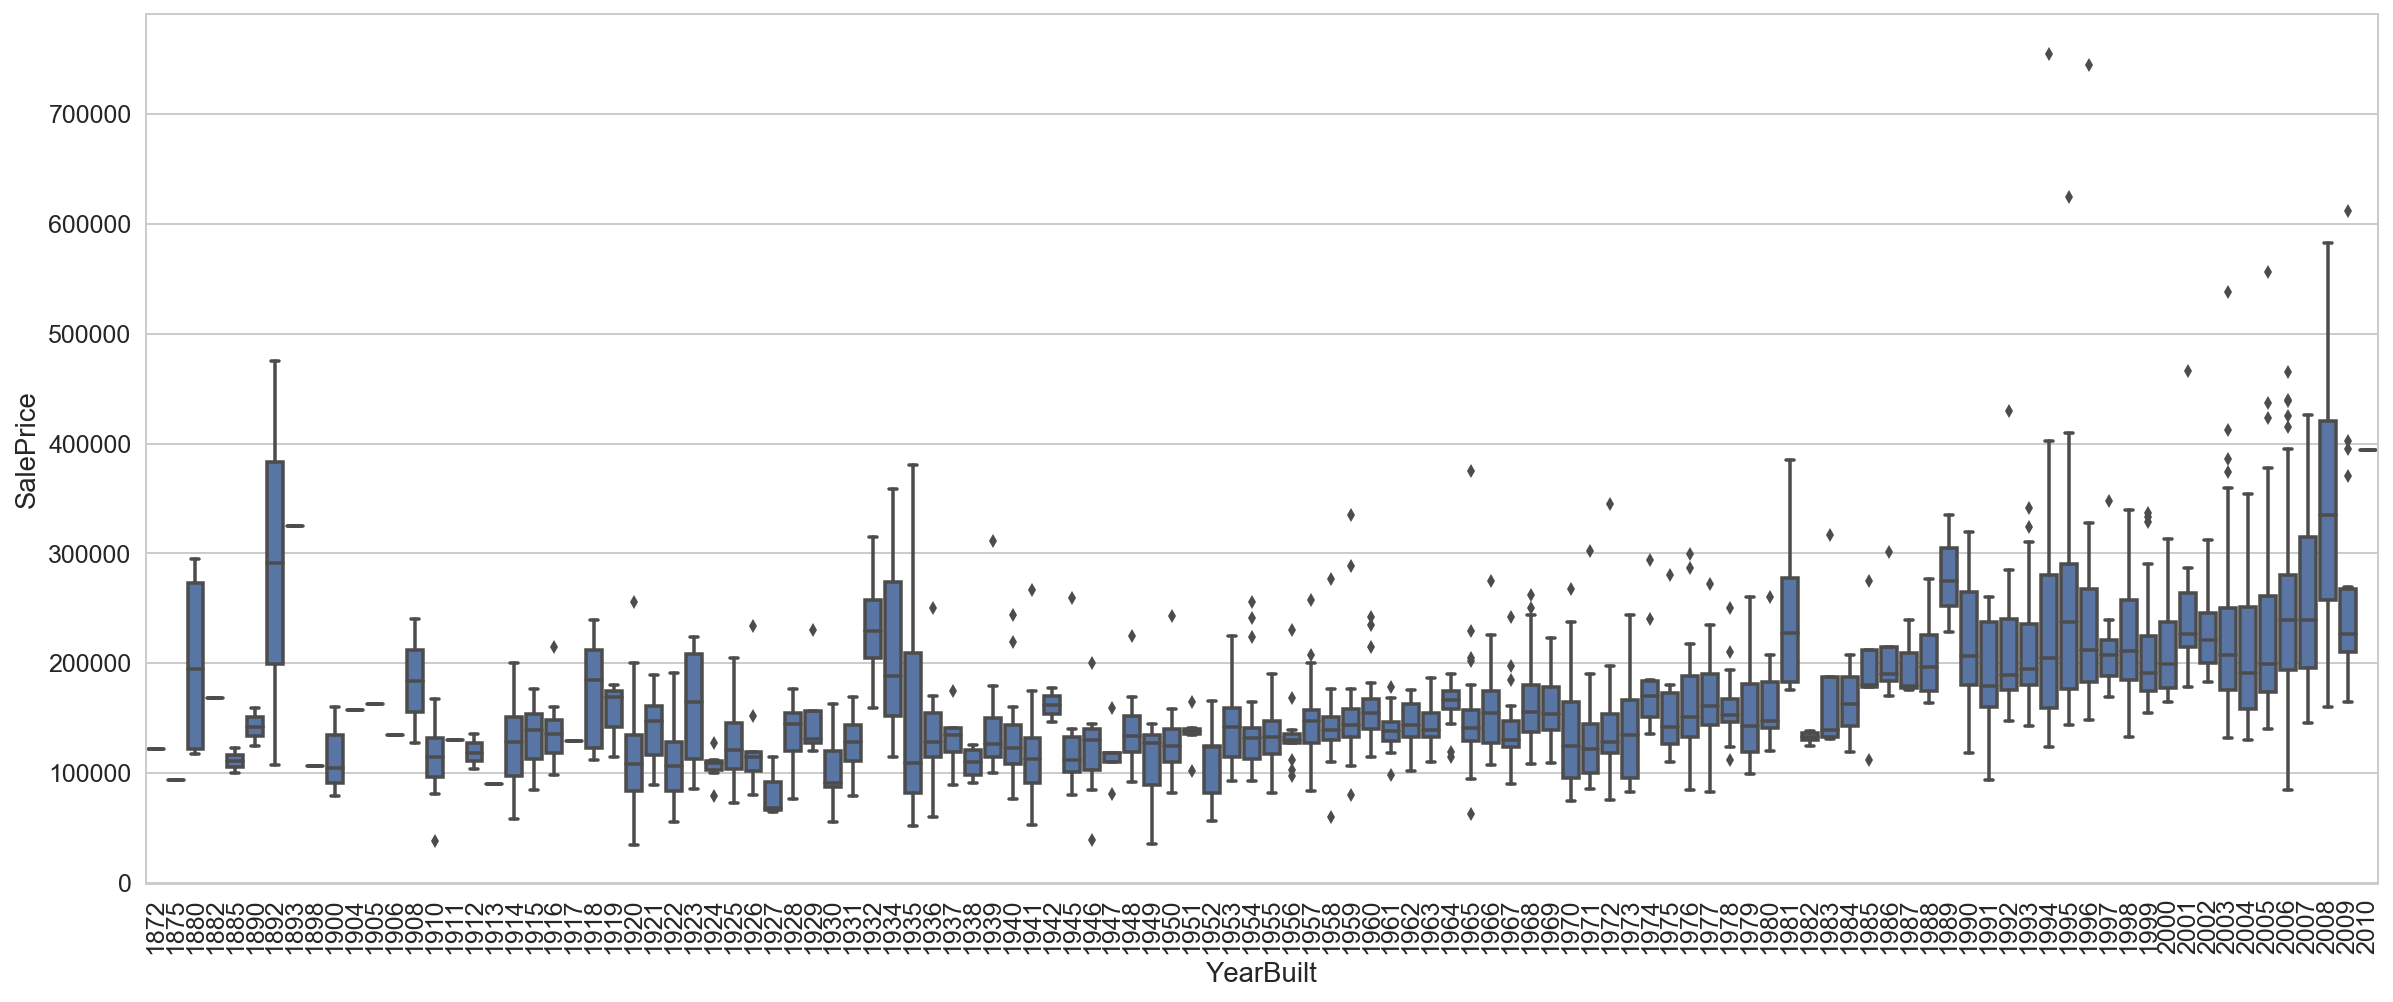

In [45]:
figure(figsize=(20, 8))
sns.boxplot(x='YearBuilt', y='SalePrice', data=train, palette=sns.color_palette(n_colors=1))
plt.xticks(rotation=90);

# 2. Data preprocessing

## 2.1 Deduplication

No duplicated rows - good!

In [3]:
print('train:', train[train.duplicated()].shape[0])
print('test:', test[test.duplicated()].shape[0])

train: 0
test: 0


## 2.2 Missing data

There are many methods to deal with missing data. The best thing to do is to read the dataset metadata and try to infer with some common sense. Let's look at features with missing values case by case to choose the most appropriate methods.


Since the dataset has a time element, it can be analysed using time-series analtical techniques. However I am keen to try out some ML regression methods, so I am going to turn feature `MoSold` (Month Sold (MM)) into categorical data to capture some of the trend and seasonality in that feature. 

~~is to remove the whole feature if it contains over X% of missing values (say 40%). As there isn't much information to infer those missing values. However it could contain important information, so let's look at those features case by case~~ 

In [4]:
def train_test_combine(train, test, target_var):
    y_train = train.loc[:, target_var].astype('float64')
    X_train = train.loc[:, [x for x in train.columns if x != target_var]]
    X_test = test.loc[:, :]
    X_train_test = X_train.append(X_test)
    
    return X_train, X_test, X_train_test, y_train

In [5]:
X_train, X_test, X_train_test, y_train = train_test_combine(train, test, target_var='SalePrice')

Check the amount of missing data in each column

In [6]:
def get_missing_stats(df):
    missing_cnt = df.isnull().sum().sort_values(ascending=False)
    missing_pct = (100 * df.isnull().sum() / df.shape[0]).sort_values(ascending=False)
    missing_df = pd.DataFrame({'missing_cnt': missing_cnt, 'missing_pct': missing_pct})
    return missing_df[missing_df.missing_cnt > 0]

In [7]:
get_missing_stats(X_train_test).head(10)

,missing_cnt,missing_pct
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageCond,159,5.447071
GarageQual,159,5.447071
GarageYrBlt,159,5.447071
GarageFinish,159,5.447071


In [8]:
def clean_data(df):
    df.LotShape = pd.to_numeric(df.LotShape.map({'Reg': 3,'IR1': 2,'IR2': 1,'IR3': 0}))
    df.LandSlope = pd.to_numeric(df.LandSlope.map({'Gtl': 2,'Mod': 1,'Sev': 0}))
    df.ExterQual = pd.to_numeric(df.ExterQual.map({'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1}))
    df.ExterCond = pd.to_numeric(df.ExterCond.map({'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1}))
    df.BsmtQual = pd.to_numeric(df.BsmtQual.fillna('NA').map({'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'NA': 0}))
    df.BsmtCond = pd.to_numeric(df.BsmtCond.fillna('NA').map({'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'NA': 0}))
    df.BsmtExposure = pd.to_numeric(df.BsmtExposure.fillna('NA').map({'Gd': 4,'Av': 3,'Mn': 2,'No': 1,'NA': 0}))
    df.BsmtFinType1 = pd.to_numeric(df.BsmtFinType1.fillna('NA').map({'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1,'NA': 0}))
    df.BsmtFinType2 = pd.to_numeric(df.BsmtFinType2.fillna('NA').map({'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1,'NA': 0}))
    df.HeatingQC = pd.to_numeric(df.HeatingQC.map({'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1}))
    df.CentralAir = pd.to_numeric(df.CentralAir.map({'N': 0, 'Y': 1}))
    df.KitchenQual = pd.to_numeric(df.KitchenQual.fillna('NA').map({'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'NA': 0}))
    df.Functional = pd.to_numeric(df.Functional.map({'Typ': 7,'Min1': 6,'Min2': 5,'Mod': 4,'Maj1': 3,'Maj2': 2,'Sev': 1,'Sal': 0}))
    df.FireplaceQu = pd.to_numeric(df.FireplaceQu.fillna('NA').map({'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'NA': 0}))
    df.Electrical.fillna(df.Electrical.mode().iloc[0], inplace=True)
    df.GarageType.fillna('NA', inplace=True)
    df.GarageFinish = pd.to_numeric(df.GarageFinish.fillna('NA').map({'Fin': 3,'RFn': 2,'Unf': 1,'NA': 0}))
    df.GarageQual = pd.to_numeric(df.GarageQual.fillna('NA').map({'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'NA': 0}))
    df.GarageCond = pd.to_numeric(df.GarageCond.fillna('NA').map({'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'NA': 0}))
    df.PavedDrive = pd.to_numeric(df.PavedDrive.map({'Y': 2,'P': 1,'N': 0}))
    df.Fence = pd.to_numeric(df.Fence.fillna('NA').map({'GdPrv': 4,'MnPrv': 3,'GdWo': 2,'MnWw': 1,'NA': 0}))
    df.MiscFeature.fillna('None', inplace=True)
    df.MasVnrType.fillna('None', inplace=True)
    df.MasVnrArea.fillna(0, inplace=True)
    df.Alley.fillna('None', inplace=True)
    df.PoolQC.fillna('None', inplace=True)
    
    # Test set receives the same treatment as train set
    df.LotFrontage.fillna(df.LotFrontage.mean(), inplace=True)
    df.GarageYrBlt.fillna(-1, inplace=True)  # Has to fill a number - mean seems less wrong
    df.MSZoning.fillna(df.MSZoning.mode().iloc[0], inplace=True)
    df.Functional.fillna(df.Functional.mode().iloc[0], inplace=True)
    df.BsmtFullBath.fillna(df.BsmtFullBath.median(), inplace=True)
    df.BsmtHalfBath.fillna(df.BsmtHalfBath.median(), inplace=True)
    df.TotalBsmtSF.fillna(df.TotalBsmtSF.mean(), inplace=True)
    df.SaleType.fillna(df.SaleType.mode().iloc[0], inplace=True)
    df.GarageArea.fillna(df.GarageArea.mean(), inplace=True)
    df.Exterior1st.fillna(df.Exterior1st.mode().iloc[0], inplace=True)
    df.Exterior2nd.fillna(df.Exterior2nd.mode().iloc[0], inplace=True)
    df.BsmtUnfSF.fillna(df.BsmtUnfSF.mean(), inplace=True)
    df.GarageCars.fillna(df.GarageCars.mode().iloc[0], inplace=True)
    df.BsmtFinSF1.fillna(df.BsmtFinSF1.mean(), inplace=True)
    df.BsmtFinSF2.fillna(df.BsmtFinSF2.mean(), inplace=True)
    
    # New feature
    df['GarageAreaPerCar'] = (df['GarageArea'] / df['GarageCars']).fillna(0)
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    # Remove feature
    # In feature "Utilities", all records are "AllPub", except for one "NoSeWa" and 2 NA . 
    # Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling
    df.drop(['Utilities','GarageArea', 'GarageCars'] , axis=1, inplace=True)         
    
    # Numerical features that are actually categorical
    df.MSSubClass = df.MSSubClass.map({20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"})
    df.MoSold = df.MoSold.map({1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                               7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"})
    
    # get columns that are strings
    str_cols = [x for x in df.columns if df[x].dtype == 'O']

    # replace space or symbols with '_' and convert to lower case (to make it nice and neat)
    df[str_cols] = df[str_cols].apply(lambda x: x.str.replace(r"\W", '_')  # replace with '_'
                                                 .str.replace('_+', '_')   # replace '_'s with '_'
                                                 .str.lower())
    
    return df

In [9]:
X_train_test = clean_data(X_train_test)
print(get_missing_stats(X_train_test))
print(X_train_test.shape)

Empty DataFrame
Columns: [missing_cnt, missing_pct]
Index: []
(2919, 78)


## 2.3 Dummy variables

Standardisation can help improve convergence of linear regression gradient descent algorithm. However I will be using tree-based models so standardisation or predictor normality are not required.

In [10]:
X_train_test_dummies = pd.get_dummies(X_train_test)

In [11]:
print('Original number of features:', X_train.shape[1])
print('New number of features:', X_train_test_dummies.shape[1])

Original number of features: 79
New number of features: 252


In [13]:
X_train_ = X_train_test_dummies[:X_train.shape[0]]
X_test_ = X_train_test_dummies[X_train.shape[0]:]

## 2.4 Outlier removal

No model is immune to outliers, so this is an important step in data preprocessing. I will produce a residual plot showing the difference between the true target variables and predicted responses from a random forest regression.

In addition to evaluating model performance, a residual plot can be used to graphically detect outliers, which are represented by the points with a large deviation from the centreline. 

In [14]:
class OutlierIdentifier(object):
    """
    Determine outliers graphically using a residual plot. Specify an estimator to make predictions.
    """
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
        
    def transform(self, X):
        y_pred = self.estimator.predict(X)
        self.y_pred_ = y_pred
        return y_pred
    
    def get_residuals(self, y_true):
        residuals = self.y_pred_ - y_true
        self.residuals_ = residuals
        return residuals
    
    def plot_residuals(self, y_true):
        figure(figsize=(11, 6))

        residuals = self.get_residuals(y_true)
        plt.scatter(self.y_pred_,
                    residuals,
                    c='blue',
                    marker='o',
                    s=35,
                    alpha=0.5
                   )
        
        plt.xlabel('Predicted label')
        plt.ylabel('Residuals')
        plt.hlines(y=0, 
                   xmin=self.y_pred_.min()-0.5, 
                   xmax=self.y_pred_.max()+0.5, 
                   lw=2, 
                   colors='r')
        plt.show()

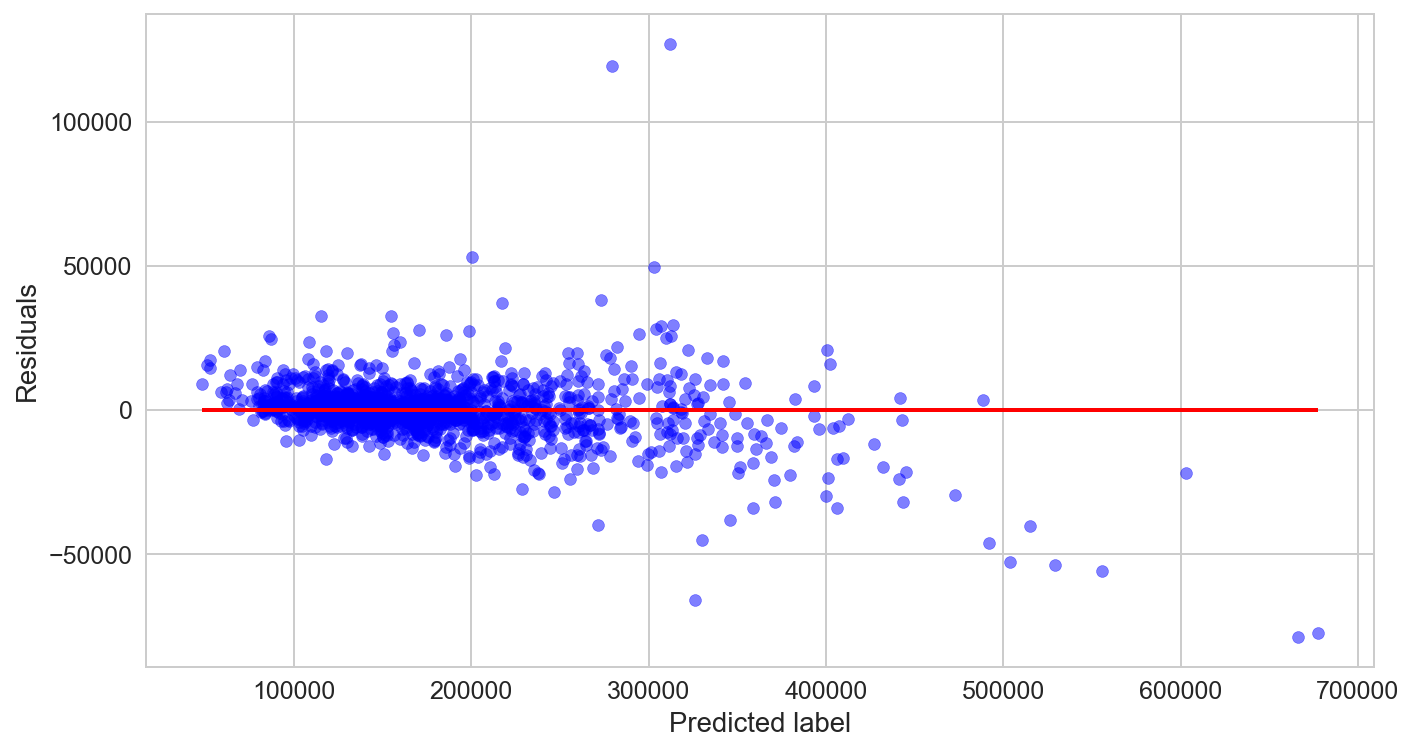

In [15]:
rfr = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
outlier_idr = OutlierIdentifier(rfr)
outlier_idr.fit(X_train_, y_train).transform(X_train_)
outlier_idr.plot_residuals(y_train.ravel())

By inspecting the residual plot above, we can see there are two obvious data points that deviate from the main cluster. They are the points that have residuals >100,000. In general we have a pre-defined threshold to identify outliers. The value of the threshold is problem-specific which is one disadvantage of this method. 

In [16]:
# identify outliers
outliers = np.argwhere(outlier_idr.residuals_ > 100000)
outlier_idx = X_train_.iloc[outliers.ravel()].index.tolist()

# remove outliers
X_train_ = X_train_.drop(labels=outlier_idx, axis=0)
y_train_ = y_train.drop(labels=outlier_idx, axis=0)

print('Outliers identified from residual plot and removed:', outlier_idx)

Outliers identified from residual plot and removed: [524, 1299]


## 3. Modelling

- The strategy is to create a stacking model using four commonly used tree-based regression models
- Ensemble tree-based models are chosen because
 - Multicollinearity problem is alleviated since a random subset of features is chosen for each tree in a random forest ([further reading](https://www.quora.com/Does-the-random-forests-technique-suffer-if-there-is-a-multi-colinerarity-present-in-the-features-data-when-trying-to-predict-the-classification-of-the-next-datapoint-If-not-why))
 - Does not require feature scaling ([further reading](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/))
- A stacking model is used because each base model has its own strengths and weaknesses and a stacking model is able to help emphasise where those base models agree with each other
- The stacking model will consist of different versions of random forest and xgboost

One of the ways to diagnose bias and variance problems is inspect learning curves. Below I define a method to plot a learning or validation curve. 

In [17]:
def plot_learn_valid_curves(sizes, train_scores, test_scores, xlabel, ylabel, xscale=None):
    """
    Method to plot a learning or validation curve
    """
    train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
    test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

    plt.plot(sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
    plt.fill_between(sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

    plt.grid()
    if xscale is not None: 
        plt.xscale(xscale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='lower right')
    plt.show()

### 3.1 Random forest regression


Here I use a random search to tune hyperparameters

In [25]:
rs_rfr_deep = RandomizedSearchCV(
                            estimator=RandomForestRegressor(n_estimators=5000, 
                                                            criterion='mse', 
                                                            random_state=1, 
                                                            n_jobs=-1),
                            param_distributions={"max_features": ['auto', 'sqrt', 'log2'],
                                                 "min_samples_split": randint(2, 50),
                                                 "min_samples_leaf": randint(2, 50),
                                                 "max_depth": randint(11, 30)},  # deep
                            n_iter=50,
                            scoring='r2',
                            n_jobs=-1,
                            cv=5,
                            verbose=1)

rs_rfr_deep.fit(X_train_, y_train)

print('Best params:', rs_rfr_deep.best_params_)
print('Best score:', rs_rfr_deep.best_score_)

# Outputs
# -------
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# [Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
# [Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.5min
# [Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 29.4min finished
# Best params: {'max_depth': 28, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 13}
# Best score: 0.878243756537

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 29.4min finished


Best params: {'max_depth': 28, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 13}
Best score: 0.878243756537


**Learning curve interpretation**

The learning curve below shows the model suffers from high variance because the training curve has very high scores while there is a large gap between the training and validation curves.

To address issues with high variance:
- Tune parameters `max_depth` and `max_features` that govern the number of splits and features respectively that are randomly chosen to grow each tree from the bootstrapped data
- Increase number of trees

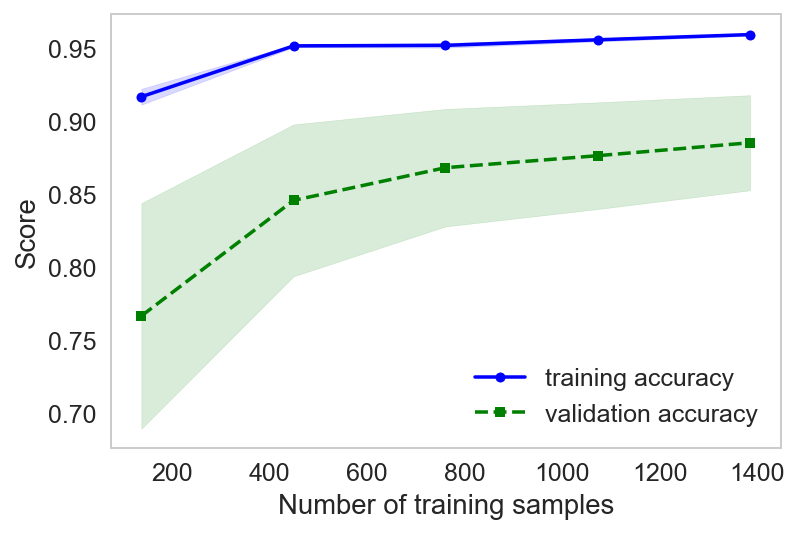

In [94]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator=rs_rfr_deep.best_estimator_,
                   X=X_train_std,
                   y=y_train_std,
                   train_sizes=np.linspace(0.1, 1.0, 5),
                   cv=20,
                   scoring='r2',
                   n_jobs=-1,
                   verbose=1)

plot_learn_valid_curves(train_sizes_learn, train_scores_learn, test_scores_learn, 
                        'Number of training samples', 'Score')

print('train_scores:', train_scores_learn.mean(axis=1))
print('test_scores:', test_scores_learn.mean(axis=1))

# Outputs
# -------
# [learning_curve] Training set sizes: [ 138  450  761 1073 1385]
# [Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.3min finished
# train_scores: [ 0.91686497  0.95166994  0.95202024  0.95582436  0.95939184]
# test_scores: [ 0.76684813  0.84594938  0.86830226  0.87652028  0.88539374]

To understand further how each parameter influences the MSE, I will change a parameter at a time and observe the change in MSE. By doing so, I hope I will be able to find a better hyperparamter combination than the one above.

**1. Investigate MSE vs n_estimators**

Validation curve below shows that there is NO benefit from increasing the number of trees above 500 *with the parameters specified*. However this can change with different parameters. To ensure sufficient variance, the number of trees will be set to 1000.

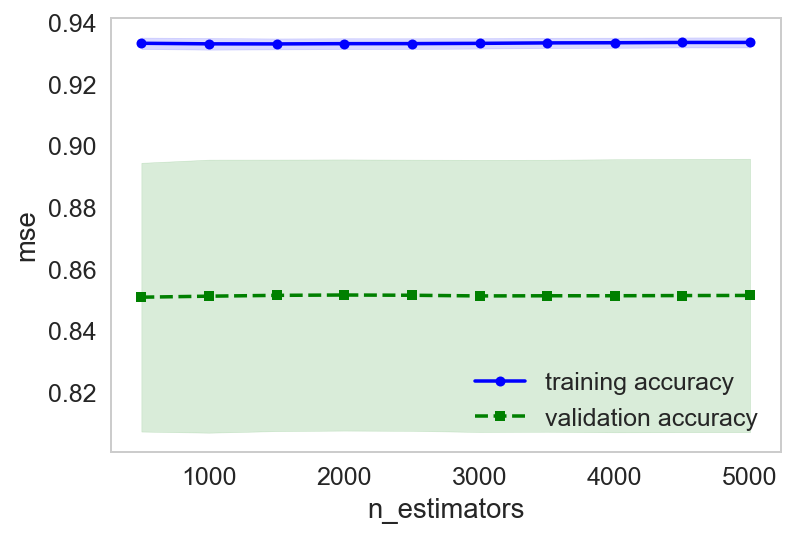

In [56]:
param_range = list(range(500, 5001, 500))

train_scores, test_scores = validation_curve(
                estimator=RandomForestRegressor(criterion='mse', random_state=1, 
                                                n_jobs=-1, max_depth=28, max_features='auto', min_samples_leaf=4, 
                                                min_samples_split=13),
                X=X_train_,
                y=y_train,
                param_name='n_estimators',
                param_range=param_range,
                cv=10,
                verbose=1)

plot_learn_valid_curves(param_range, train_scores, test_scores, 'n_estimators', 'mse')

**2. Investigate MSE vs max_depth**

Validation curve below shows that `max_depth` is optimal between 10 and 15, hence set it to 13.

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  5.6min finished


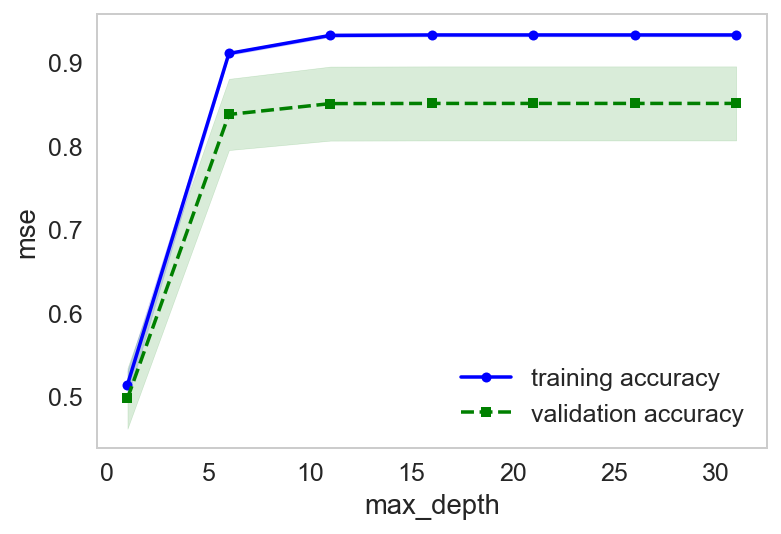

In [64]:
param_range = list(range(1, 32, 5))

train_scores, test_scores = validation_curve(
                estimator=RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, 
                                                n_jobs=-1, max_features='auto', min_samples_leaf=4, 
                                                min_samples_split=13),
                X=X_train_,
                y=y_train,
                param_name='max_depth',
                param_range=param_range,
                cv=10,
                verbose=1)

plot_learn_valid_curves(param_range, train_scores, test_scores, 'max_depth', 'mse')

**3. Investigate MSE vs max_features**

Validation curve shows optimal `max_features` is between 60 and 100, hence set `max_features` to 80.

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.6min finished


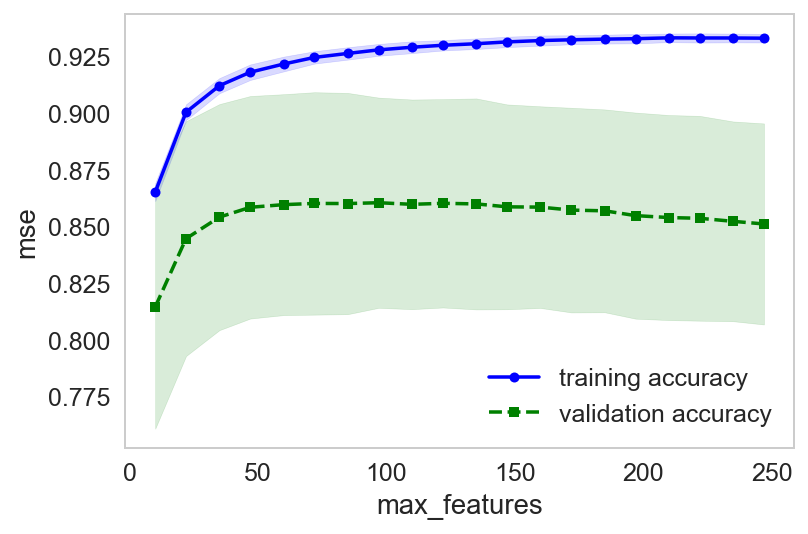

In [74]:
param_range = np.round(np.linspace(10, X_train_.shape[1], 20)).astype(int)

train_scores, test_scores = validation_curve(
                estimator=RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, 
                                                n_jobs=-1, max_depth=13, min_samples_leaf=4, 
                                                min_samples_split=13),
                X=X_train_,
                y=y_train,
                param_name='max_features',
                param_range=param_range,
                cv=10,
                verbose=1)

plot_learn_valid_curves(param_range, train_scores, test_scores, 'max_features', 'mse')

**4. Investigate MSE vs min_samples_leaf**

Validation curve shows optimal `min_samples_leaf` is around 2.

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.5min finished


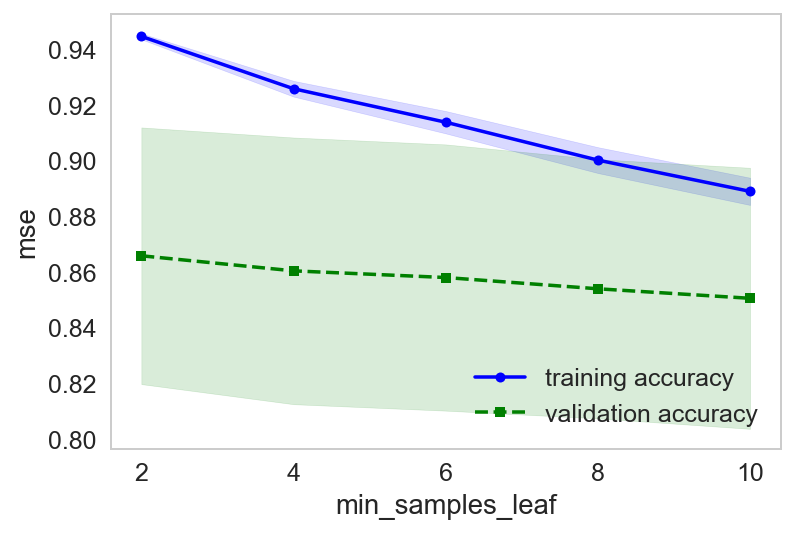

In [77]:
param_range = np.round(np.linspace(2, 10, 5)).astype(int)

train_scores, test_scores = validation_curve(
                estimator=RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, 
                                                n_jobs=-1, max_depth=13, max_features=80, 
                                                min_samples_split=13),
                X=X_train_,
                y=y_train,
                param_name='min_samples_leaf',
                param_range=param_range,
                cv=10,
                verbose=1)

plot_learn_valid_curves(param_range, train_scores, test_scores, 'min_samples_leaf', 'mse')

**5. Investigate MSE vs min_samples_split**

Validation curve shows optimal `min_samples_split` is between 2 and 6, hence set to 4.

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.1min finished


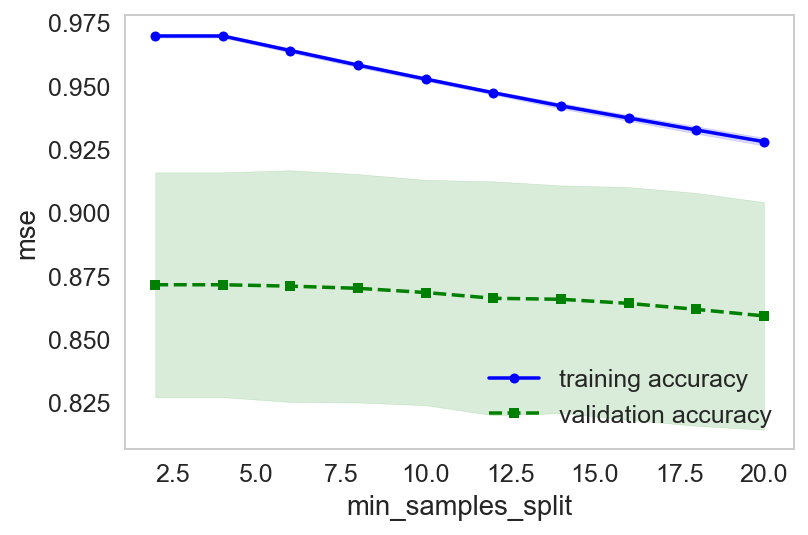

In [81]:
param_range = np.round(np.linspace(2, 20, 10)).astype(int)

train_scores, test_scores = validation_curve(
                estimator=RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, 
                                                n_jobs=-1, max_depth=13, max_features=80, min_samples_leaf=2),
                X=X_train_,
                y=y_train,
                param_name='min_samples_split',
                param_range=param_range,
                cv=10,
                verbose=1)

plot_learn_valid_curves(param_range, train_scores, test_scores, 'min_samples_split', 'mse')

**6. Random search**

Hyperparameter tuning from the above analysis is very useful in understanding the changes in performance when tuning a single parameter. However to further improve performance one needs to find the *optimal* (or sufficiently good) combinations of hyperparameter values. This is done below with search ranges around the optimal values I found in the analysis above.

In [84]:
rs_rfr = RandomizedSearchCV(
                            estimator=RandomForestRegressor(n_estimators=1000, 
                                                            criterion='mse', 
                                                            random_state=1, 
                                                            n_jobs=-1),
                            param_distributions={"max_features": randint(50, 100),
                                                 "min_samples_split": randint(2, 7),
                                                 "min_samples_leaf": randint(1, 4),
                                                 "max_depth": randint(10, 15)},
                            n_iter=50,
                            scoring='r2',
                            n_jobs=-1,
                            cv=5,
                            verbose=1)

rs_rfr.fit(X_train_, y_train)

print('Best params:', rs_rfr.best_params_)
print('Best score:', rs_rfr.best_score_)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  8.9min finished


Best params: {'max_depth': 14, 'max_features': 78, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.87048160974


Although the original setting from the first random search is a little bit better, both will be used in the stacking model. To avoid losing the settings after restarting this notebook, I hard coded the two regressors below.

In [26]:
rfr1 = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=28, max_features='auto', 
                             min_samples_leaf=4, min_samples_split=13, random_state=1, n_jobs=-1)
rfr1.fit(X_train_, y_train_)

rfr2 = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=14, max_features=78, 
                             min_samples_leaf=1, min_samples_split=2, random_state=1, n_jobs=-1)
rfr2.fit(X_train_, y_train_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features=78, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

**Feature importance**

Out of curiosity, let's look at the feature importance below. As expected, the 'overall quality' and areas/sizes are the most important features for home buyers. 

In [118]:
# feature importance
importances = rfr1.feature_importances_
indices = np.argsort(importances)[::-1]
feat_labels = X_train_.columns
feat_imp = pd.DataFrame({'Feature': feat_labels, 'Importance': importances})\
             .sort_values('Importance', ascending=False)
feat_imp.head(10)

,Feature,Importance
4,OverallQual,0.628704
25,GrLivArea,0.118889
19,TotalBsmtSF,0.046006
15,BsmtFinSF1,0.026991
22,1stFlrSF,0.023013
23,2ndFlrSF,0.018659
1,LotArea,0.013145
6,YearBuilt,0.009198
28,FullBath,0.008181
7,YearRemodAdd,0.007213


Using sci-kit learn's `Pipeline` and `SelectFromModel`, the graph below shows how the performance degrades dramatically when the importance threshold increases, filtering out many seemingly less important features. Therefore I will keep all features in this case, but for practical scenarios I will remove some features to keep the model as simple as possible.

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 12.0min finished


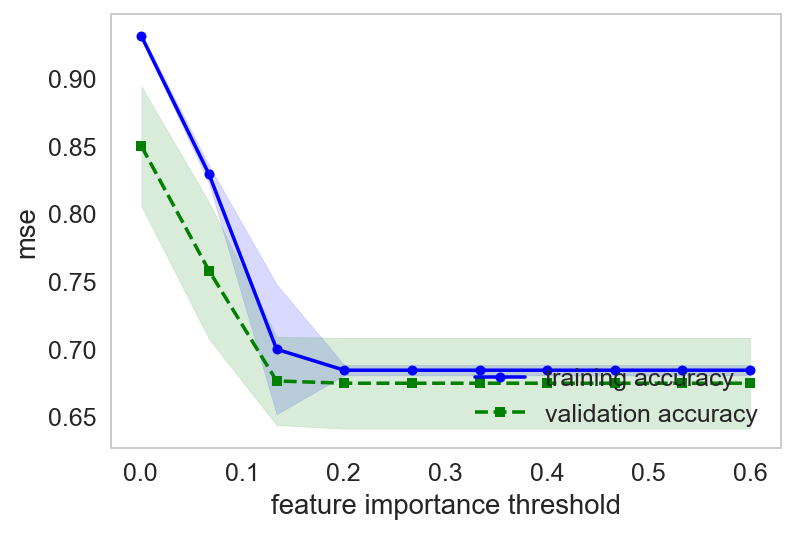

In [122]:
regressor = Pipeline([
  ('feature_selection', SelectFromModel(rfr1, prefit=False)),
  ('regression', rfr1)])

param_range = np.linspace(0.001, 0.6, 10)

train_scores, test_scores = validation_curve(
                estimator=regressor,
                X=X_train_,
                y=y_train,
                param_name='feature_selection__threshold',
                param_range=param_range,
                cv=10,
                verbose=1)

plot_learn_valid_curves(param_range, train_scores, test_scores, 'feature importance threshold', 'mse')

### 3.3 XGBoost regression

Useful reading for XGBoost:
- https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [18]:
xgbr = XGBRegressor(n_estimators=1000, silent=1, n_jobs=-1, random_state=0)

param_dist = {'learning_rate': uniform(0, 0.3),
              'max_depth': randint(3, 10),
              'min_child_weight': uniform(1, 4),
              'subsample': uniform(0.5, 0.5),
              'colsample_bytree': uniform(0.4, 0.6),
              'colsample_bylevel': uniform(0.4, 0.6),
              'gamma': uniform(0., 1.),
              'reg_alpha': uniform(0., 10.),
              'reg_lambda': uniform(0., 10.)}

rs_xgbr = RandomizedSearchCV(
                estimator=xgbr,
                param_distributions=param_dist,
                n_iter=50,
                scoring='r2',
                n_jobs=-1,
                cv=5,
                verbose=1)

rs_xgbr.fit(X_train_, y_train_)

print('Best params:', rs_xgbr.best_params_)
print('Best score:', rs_xgbr.best_score_)

# Outputs
# -------
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
# [Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.8min
# [Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 12.2min finished
# Best params: {'colsample_bylevel': 0.8196963876378829, 'colsample_bytree': 0.9223073136562492, 'gamma': 0.1311035724787274, 'learning_rate': 0.07381882469434756, 'max_depth': 4, 'min_child_weight': 2.9292037349523015, 'reg_alpha': 9.796329276781254, 'reg_lambda': 2.883322440109489, 'subsample': 0.6737567246802627}
# Best score: 0.9247806442111626

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 12.2min finished


Best params: {'colsample_bylevel': 0.8196963876378829, 'colsample_bytree': 0.9223073136562492, 'gamma': 0.1311035724787274, 'learning_rate': 0.07381882469434756, 'max_depth': 4, 'min_child_weight': 2.9292037349523015, 'reg_alpha': 9.796329276781254, 'reg_lambda': 2.883322440109489, 'subsample': 0.6737567246802627}
Best score: 0.9247806442111626


[learning_curve] Training set sizes: [ 138  450  761 1073 1385]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished


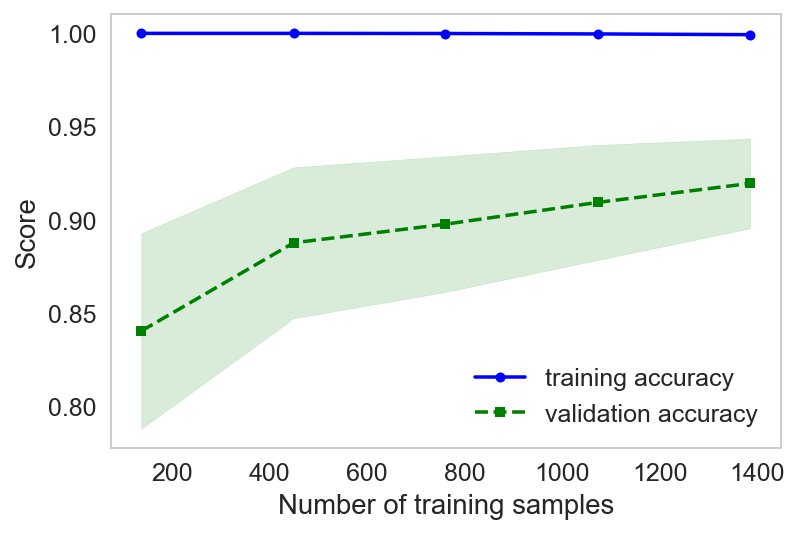

train_scores: [0.99999999 0.99999619 0.99992083 0.99969464 0.99929996]
test_scores: [0.84046897 0.8877375  0.89771324 0.90938874 0.91955615]


In [20]:
# copying the best parameters from random search to avoive losing this info after restarting notebook
kwargs = {'colsample_bylevel': 0.8197, 'colsample_bytree': 0.9223, 
          'gamma': 0.1311, 'learning_rate': 0.0738, 'max_depth': 4, 
          'min_child_weight': 2.9292, 'reg_alpha': 9.7963, 
          'reg_lambda': 2.8833, 'subsample': 0.6738}

xgbr1 = XGBRegressor(n_estimators=1000, silent=1, n_jobs=-1, random_state=0, **kwargs) 

train_sizes_learn, train_scores_learn, test_scores_learn = learning_curve(estimator=xgbr1,
                                                                          X=X_train_,
                                                                          y=y_train_,
                                                                          train_sizes=np.linspace(0.1, 1.0, 5),
                                                                          cv=20,
                                                                          scoring='r2',
                                                                          n_jobs=-1,
                                                                          verbose=1)

plot_learn_valid_curves(train_sizes_learn, train_scores_learn, test_scores_learn, 
                        'Number of training samples', 'Score')

print('train_scores:', train_scores_learn.mean(axis=1))
print('test_scores:', test_scores_learn.mean(axis=1))

Creating another `XGBRegressor` to be used in the stacking model

[learning_curve] Training set sizes: [ 138  450  761 1073 1385]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


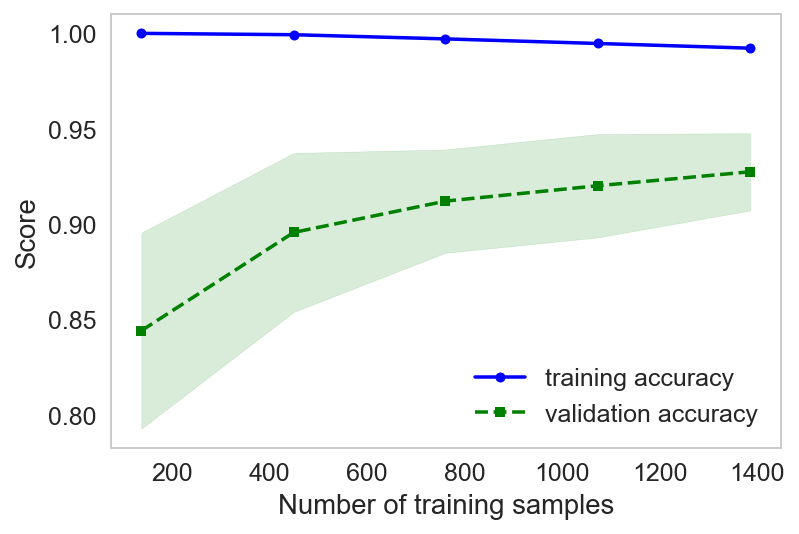

train_scores: [0.99999285 0.9992837  0.99709393 0.99468987 0.99222863]
test_scores: [0.84410137 0.89560561 0.91204086 0.92010427 0.92740519]


In [21]:
xgbr2 = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                     learning_rate=0.05, max_depth=3, 
                     min_child_weight=1.7817, n_estimators=1000,
                     reg_alpha=0.4640, reg_lambda=0.8571,
                     subsample=0.5213, silent=1,
                     random_state=1, n_jobs=-1)

train_sizes_learn, train_scores_learn, test_scores_learn = learning_curve(estimator=xgbr2,
                                                                          X=X_train_,
                                                                          y=y_train_,
                                                                          train_sizes=np.linspace(0.1, 1.0, 5),
                                                                          cv=20,
                                                                          scoring='r2',
                                                                          n_jobs=-1,
                                                                          verbose=1)

plot_learn_valid_curves(train_sizes_learn, train_scores_learn, test_scores_learn, 
                        'Number of training samples', 'Score')

print('train_scores:', train_scores_learn.mean(axis=1))
print('test_scores:', test_scores_learn.mean(axis=1))

### 3.4 Stacking model

- Stacking is a mechanism that tries to leverage the benefits of each algorithm while disregarding (to some extent) or correcting for their disadvantages ([further reading](http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/))
- A meta-learner uses the outputs from different base models as inputs to train another algorithm (N.B. the meta-learner has no access to the original data)
- Ideally you can assign weights to each model according to how much you believe in each model (perhaps from historical performances of the models)
- The following implementation is based on this Kaggle kernel: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
- Useful advices from [Stacking Made Easy: An Introduction to StackNet by Competitions Grandmaster Marios Michailidis (KazAnova)](http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/):

```
As a quick note, one should try a few diverse models. To my experience, a good stacking solution is often composed of at least:
- 2 or 3 GBMs (one with low depth, one with medium and one with high)
- 1 or 2 Random Forests (again as diverse as possible–one low depth, one high)
- 1 or 2 NNs (one deeper, one smaller)
- 1 linear model```

In [78]:
class StackedRegressor(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_splits=5, meta_param_dist=None, random_state=None):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_splits = n_splits
        self.meta_param_dist = meta_param_dist
        self.random_state = random_state
   
    def fit(self, X, y):
        self.base_models_ = [clone(x) for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models_)))
        for i, model in enumerate(self.base_models_):
            for train_index, holdout_index in kf.split(X):
                model.fit(X[train_index], y[train_index])
                y_pred = model.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new features
        if self.meta_param_dist is not None:
            rscv = RandomizedSearchCV(
                        estimator=self.meta_model_,
                        param_distributions=self.meta_param_dist,
                        n_iter=50,
                        scoring='r2',
                        n_jobs=-1,
                        cv=5,
                        verbose=1)
            
            rscv.fit(out_of_fold_predictions, y)
            self.meta_model_ = rscv.best_estimator_
        else:
            self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([model.predict(X) for model in self.base_models_])
        return self.meta_model_.predict(meta_features)

In [68]:
param_dist = {'learning_rate': uniform(0, 0.3),
              'max_depth': randint(3, 10),
              'min_child_weight': uniform(1, 4),
              'subsample': uniform(0.5, 0.5),
              'colsample_bytree': uniform(0.4, 0.6),
              'colsample_bylevel': uniform(0.4, 0.6),
              'gamma': uniform(0., 1.),
              'reg_alpha': uniform(0., 10.),
              'reg_lambda': uniform(0., 10.)}

stacked_regressor = StackedRegressor(base_models=[rfr1, rfr2, xgbr1, xgbr2],
                                     meta_model=XGBRegressor(n_estimators=1000, silent=1, n_jobs=-1, random_state=0), 
                                     n_splits=5, 
                                     meta_param_dist=param_dist, 
                                     random_state=1)

stacked_regressor.fit(X_train_.values, y_train_.values)

# tuned meta model
# XGBRegressor(base_score=0.5, booster='gbtree',
#        colsample_bylevel=0.5737721353151635,
#        colsample_bytree=0.9140210737871712, gamma=0.8839948032221018,
#        learning_rate=0.018328401615017743, max_delta_step=0, max_depth=6,
#        min_child_weight=1.998605304684518, missing=None, n_estimators=1000,
#        n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
#        reg_alpha=6.5050343125866075, reg_lambda=8.234701262665236,
#        scale_pos_weight=1, seed=None, silent=1,
#        subsample=0.5712246022815494)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   46.4s finished


StackedRegressor(base_models=[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=13,
           min_weight_fraction_leaf=0.0, n_estima...=0.464,
       reg_lambda=0.8571, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.5213)],
         meta_model=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=1),
         meta_param_dist={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1a5e7518>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen objec

[learning_curve] Training set sizes: [ 131  426  721 1016 1312]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 42.8min finished


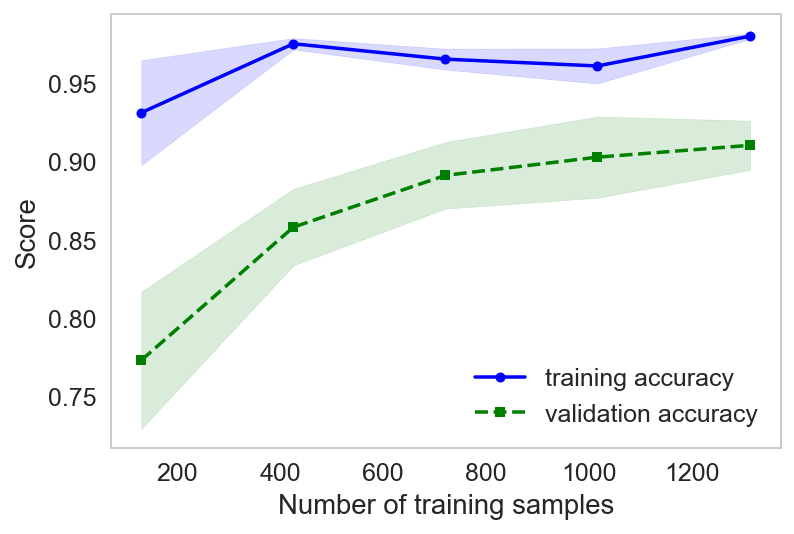

train_scores: [0.93121456 0.97528176 0.96543308 0.96107316 0.98015106]
test_scores: [0.77296013 0.85803524 0.89113926 0.9027771  0.91034203]


In [72]:
meta_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5738,
                          colsample_bytree=0.9140, gamma=0.8840,
                          learning_rate=0.0183, max_delta_step=0, max_depth=6,
                          min_child_weight=1.9986, missing=None, n_estimators=1000,
                          n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
                          reg_alpha=6.5050, reg_lambda=8.2347,
                          scale_pos_weight=1, seed=None, silent=1,
                          subsample=0.5712)

stacked_regressor = StackedRegressor(base_models=[rfr1, rfr2, xgbr1, xgbr2],
                                     meta_model=meta_model, 
                                     n_splits=5, 
                                     meta_param_dist=None, 
                                     random_state=1)

train_sizes_learn, train_scores_learn, test_scores_learn = learning_curve(estimator=stacked_regressor,
                                                                          X=X_train_.values,
                                                                          y=y_train_.values,
                                                                          train_sizes=np.linspace(0.1, 1.0, 5),
                                                                          cv=10,
                                                                          scoring='r2',
                                                                          n_jobs=1,
                                                                          verbose=1)

plot_learn_valid_curves(train_sizes_learn, train_scores_learn, test_scores_learn, 
                        'Number of training samples', 'Score')

print('train_scores:', train_scores_learn.mean(axis=1))
print('test_scores:', test_scores_learn.mean(axis=1))

## 7. Deployment

In [82]:
stacked_regressor = StackedRegressor(base_models=[rfr1, rfr2, xgbr1, xgbr2],
                                     meta_model=meta_model, 
                                     n_splits=5, 
                                     meta_param_dist=None, 
                                     random_state=1)

stacked_regressor.fit(X_train_.values, y_train_.values)

y_pred = stacked_regressor.predict(X_test_.values)

In [87]:
pd.DataFrame(data={'Id': X_test.index, 'SalePrice': y_pred}).to_csv('submission7.csv', index=False)

## 8. References

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python  
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook  
http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/  